In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from haversine import haversine
import re
import gc
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns

## data load

In [90]:
train = pd.read_parquet('./train07.parquet') # 7월 only 
test = pd.read_parquet('./test.parquet')
print(train.shape, test.shape)

(274695, 23) (291241, 22)


## 데이터 전처리

### base_date
train_base_date_df = train.groupby(['base_date','road_name']).count()[['id']].reset_index()
test_base_date_df = test.groupby(['base_date','road_name']).count()[['id']].reset_index()

train_base_date_df.columns = ['base_date','road_name','base_date_cnt']
test_base_date_df.columns = ['base_date','road_name','base_date_cnt']

train = train.merge(train_base_date_df, how='inner', on=['base_date','road_name'])
test = test.merge(test_base_date_df, how='inner', on=['base_date','road_name'])

In [91]:
# 위경도로 거리 도출
%time
train["distance"] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: haversine((x[0], x[1]), (x[2], x[3])), axis="columns")
test["distance"] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: haversine((x[0], x[1]), (x[2], x[3])), axis="columns")

Wall time: 0 ns


In [92]:
#road_cols = ['동문로','연북로','삼봉로']
train['road_name_mean'] = 0
test['road_name_mean'] = 0

train.loc[train['road_name'] == '동문로','road_name_mean'] = 23.915438
test.loc[test['road_name'] == '동문로','road_name_mean'] = 23.915438

train.loc[train['road_name'] == '연북로','road_name_mean'] = 25.510870
test.loc[test['road_name'] == '연북로','road_name_mean'] = 25.510870

train.loc[train['road_name'] == '삼봉로','road_name_mean'] = 16.577010
test.loc[test['road_name'] == '삼봉로','road_name_mean'] = 16.577010

In [93]:
# label encoding 
str_col = ['day_of_week', 'start_turn_restricted','end_turn_restricted'
          ]   
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [94]:
# one-hot
cols = ['road_type', 'start_turn_restricted', 'end_turn_restricted', 'lane_count', 'road_rating','weight_restricted', 'day_of_week'
       ]  

train = pd.get_dummies(train, prefix_sep='_', sparse=False, drop_first=True, columns = cols)
test = pd.get_dummies(test, prefix_sep='_', sparse=False, drop_first=True, columns = cols)

In [95]:
# del 
del_cols = ['id', 'connect_code','height_restricted','vehicle_restricted'
            , 'start_node_name', 'end_node_name', 'road_name'
           ]  # , 'base_date', 
train = train.drop(del_cols, axis=1)
test = test.drop(del_cols, axis=1)

In [96]:
train.corr()[['target']].abs().sort_values('target', ascending=False)

,target
target,1.000000
road_rating_107,0.388484
road_rating_106,0.301745
weight_restricted_43200.0,0.290090
road_type_3,0.260593
maximum_speed_limit,0.253601
base_hour,0.208142
distance,0.191126
start_longitude,0.166391
end_longitude,0.163042


In [76]:
#train[(train['base_date'] == 20220701) & (train['base_hour'] == 0)].sort_values('target').to_excel('temp/20220701_00.xlsx', encoding='utf-8-sig') 

## 모델링

In [97]:
gc.collect()

120

In [98]:
print(train.columns)
print(test.columns)

Index(['base_date', 'base_hour', 'multi_linked', 'maximum_speed_limit',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'target', 'distance', 'road_name_mean', 'road_type_3',
       'start_turn_restricted_1', 'end_turn_restricted_1', 'lane_count_2',
       'lane_count_3', 'road_rating_106', 'road_rating_107',
       'weight_restricted_32400.0', 'weight_restricted_43200.0',
       'weight_restricted_50000.0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')
Index(['base_date', 'base_hour', 'multi_linked', 'maximum_speed_limit',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'distance', 'road_name_mean', 'road_type_3', 'start_turn_restricted_1',
       'end_turn_restricted_1', 'lane_count_2', 'lane_count_3',
       'road_rating_106', 'road_rating_107', 'weight_restricted_32400.0',
       'weight_restricted_43200.0', 'weight_restricted

In [99]:
#train.columns = [
#test.columns = [

In [100]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
#X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1) , train['target'], test_size=0.3, shuffle=True, random_state=42)
X_train = train[train['base_date'] <= 20220720].drop('target', axis=1)
X_test = train[train['base_date'] > 20220720].drop('target', axis=1)
y_train = train[train['base_date'] <= 20220720][['target']]
y_test = train[train['base_date'] > 20220720][['target']]

X_train = X_train.drop(['base_date'], axis=1)
X_test = X_test.drop(['base_date'], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((190228, 25), (84467, 25), (190228, 1), (84467, 1))

In [101]:
%%time 
model = lgb.LGBMRegressor(random_state=42)

Wall time: 0 ns


In [102]:
%%time
model.fit(X_train, y_train)

Wall time: 1.1 s


LGBMRegressor(random_state=42)

## 예측

In [103]:
mean_absolute_error(y_test, model.predict(X_test))

3.6552957381778652

In [104]:
3.66

3.66

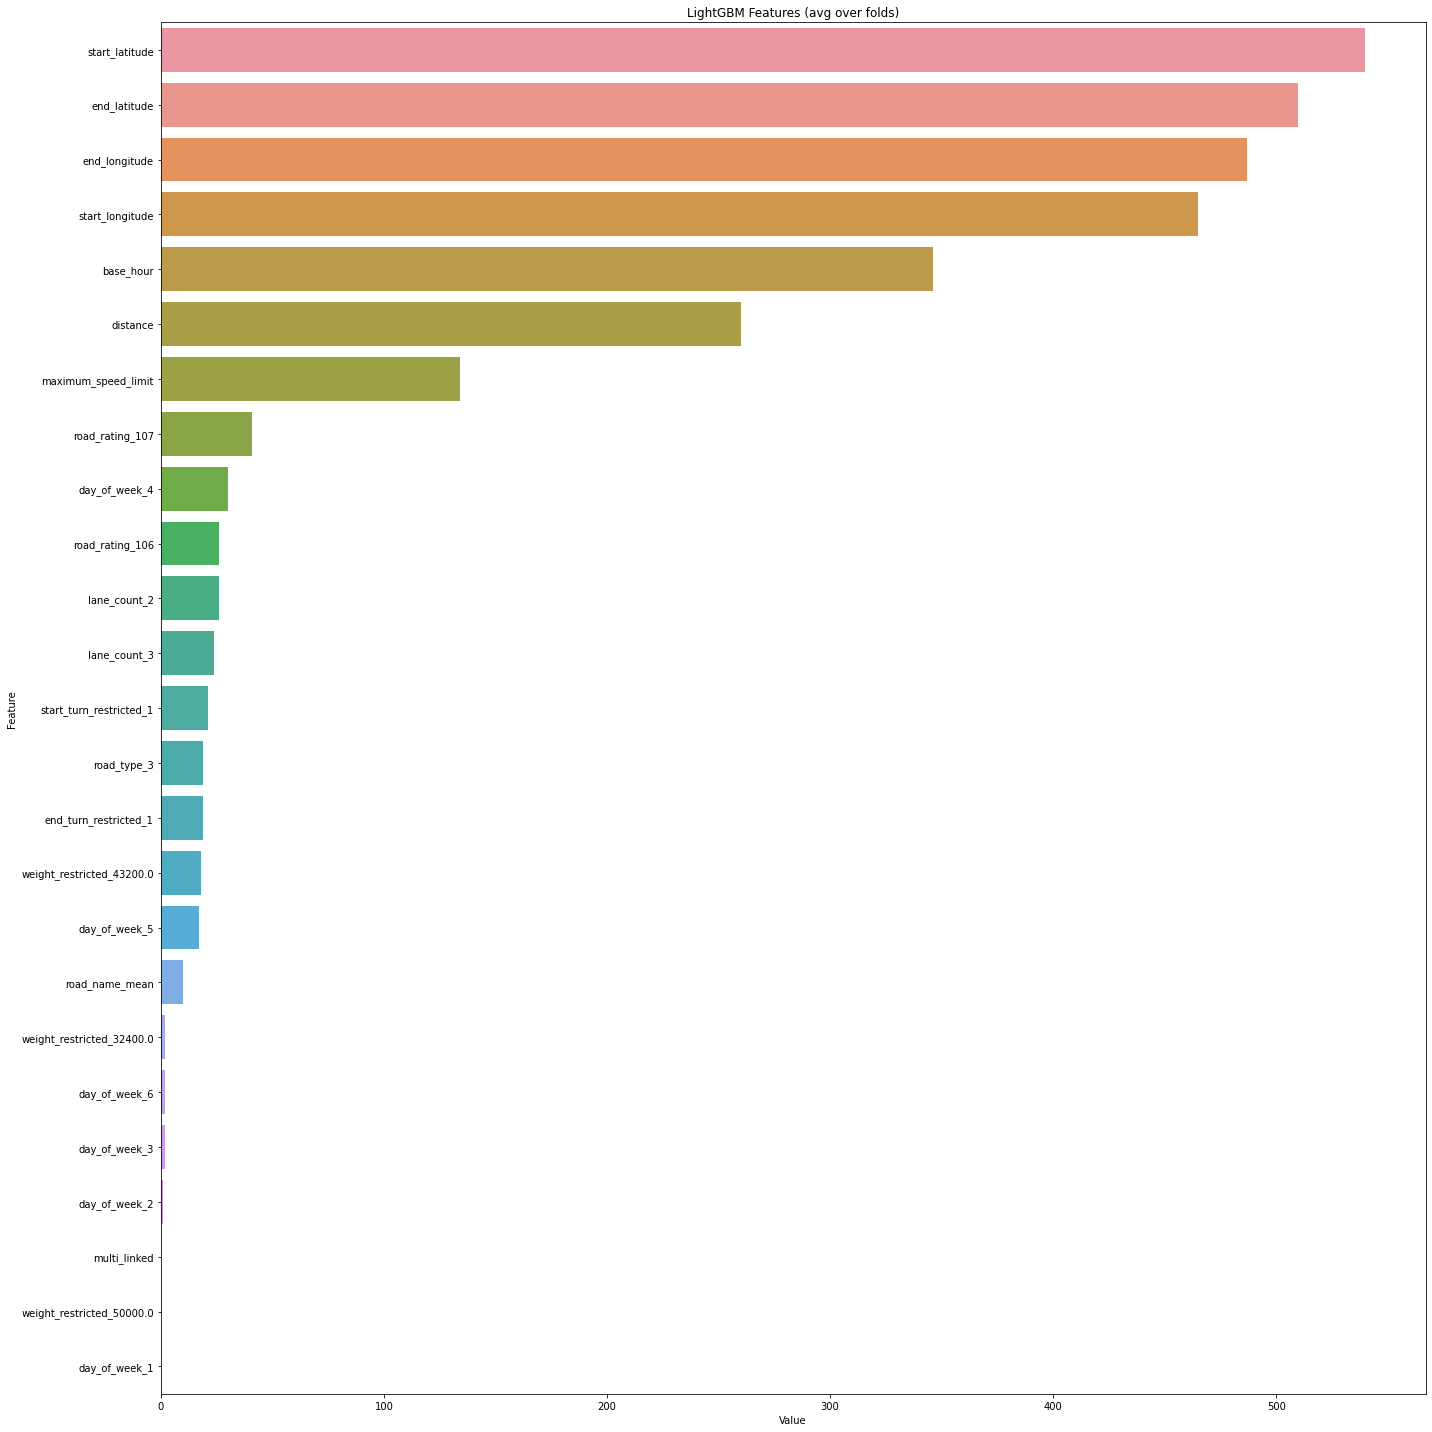

In [105]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## 제출

In [106]:
sample_submission = pd.read_csv('input/sample_submission.csv')

In [107]:
%%time
model2 = lgb.LGBMRegressor(random_state=42)

model2.fit(train.drop('target', axis=1), train['target'])

Wall time: 1.34 s


LGBMRegressor(random_state=42)

In [108]:
sample_submission['target'] = model2.predict(test)

In [109]:
sample_submission.to_csv("output/20221024-3.csv", index = False)